<a href="https://colab.research.google.com/github/Yashmaini30/Breast-Cancer-Detection/blob/main/ResNet50_on_Breast_Cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')
from __future__ import absolute_import, print_function, division, unicode_literals
import os.path
import glob
import shutil
import pandas as pd
!pip install imagehash
import imagehash
from PIL import Image
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, Activation,  GlobalAveragePooling2D
from keras import regularizers
import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.5 MB/s eta 0:00:00


In [5]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = "/content/drive/MyDrive/archive"
data_dir = pathlib.Path(data_dir)

train_path = data_dir / 'train'
test_path = data_dir / 'test'


In [6]:
# Remove Duplicates
def remove_duplicates(image_folder):
    image_hashes = {}
    duplicates = []
    for img_path in glob.glob(f'{image_folder}/**/*.png', recursive=True):
        try:
            img = Image.open(img_path)
            img_hash = imagehash.phash(img)
            if img_hash in image_hashes:
                duplicates.append(img_path)
            else:
                image_hashes[img_hash] = img_path
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    for dup in duplicates:
        os.remove(dup)
    print(f'Removed {len(duplicates)} duplicates.')


remove_duplicates(train_path)
remove_duplicates(test_path)

Removed 185 duplicates.
Removed 37 duplicates.


In [9]:
categories = os.listdir(train_path)

nums = {}
for label in categories:
    nums[label] = len(os.listdir(train_path / label))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
normal,106
malignant,334
benign,635


In [10]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.50,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_train_gen.flow_from_directory(train_path,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1075 images belonging to 3 classes.


In [11]:
img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(test_path,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='categorical')


Found 281 images belonging to 3 classes.


Training dataset:


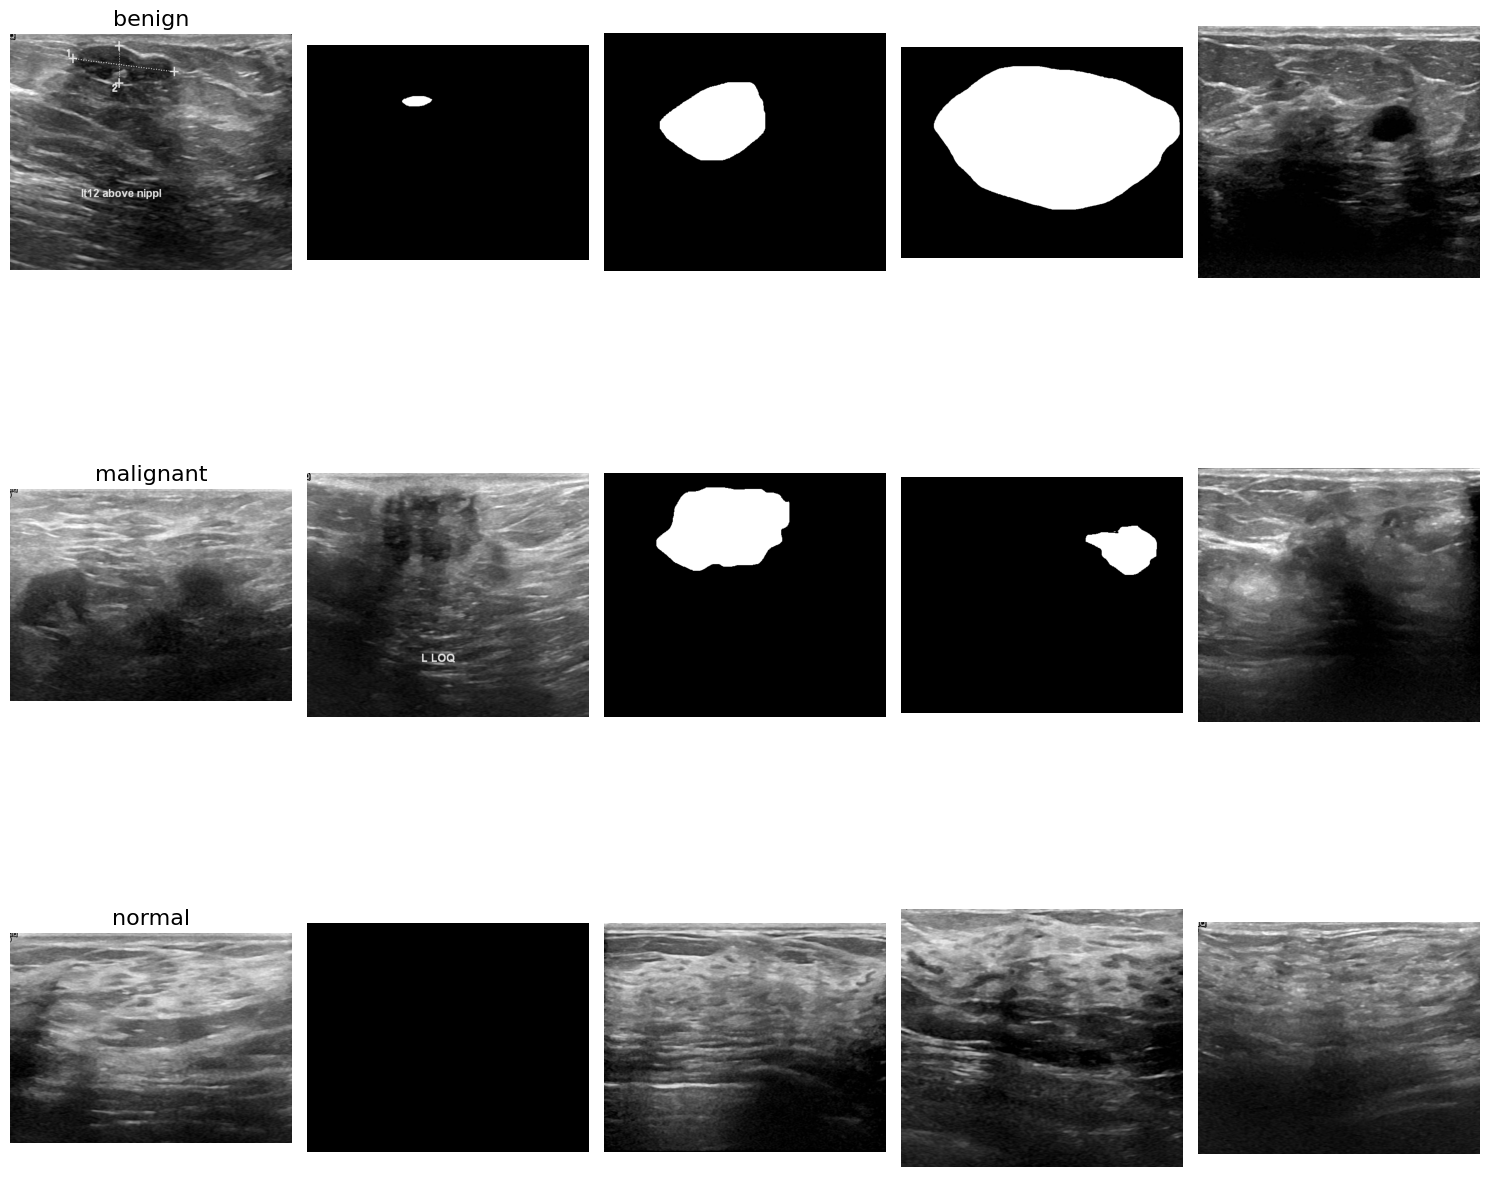

In [15]:
def display_class_images(image_folder, class_names, num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(15, 5 * len(class_names)))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(image_folder, class_name)
        image_paths = glob.glob(f'{class_path}/*.png')[:num_images]

        for j, img_path in enumerate(image_paths):
            img = Image.open(img_path)
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, size=16)

    plt.tight_layout()
    plt.show()


class_names = ['benign', 'malignant', 'normal']


print("Training dataset:")
display_class_images(train_path, class_names)



In [16]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                      include_top=False,
                      weights='imagenet')

# Freezing the base model
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation="softmax")(x)

# Building the model
model = Model(inputs=base_model.input, outputs=predictions)


In [18]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
EPOCHS = 10
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5389 - loss: 1.0249 - val_accuracy: 0.6263 - val_loss: 0.7753
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.6216 - loss: 0.8272 - val_accuracy: 0.6726 - val_loss: 0.7595
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.6144 - loss: 0.8317 - val_accuracy: 0.7295 - val_loss: 0.7372
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.6133 - loss: 0.8672 - val_accuracy: 0.7295 - val_loss: 0.6923
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.6101 - loss: 0.8642 - val_accuracy: 0.7331 - val_loss: 0.7109
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.6445 - loss: 0.8180 - val_accuracy: 0.6940 - val_loss: 0.7091
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.6578 - loss: 0.7948 - val_accuracy: 0.7331 - val_loss: 0.6767
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.6721 - loss: 0.7739 - val_accuracy: 0.729

In [20]:
val_loss, val_acc = model.evaluate(val_data_gen)
print("Validation Accuracy: ", val_acc)

36/36 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7410 - loss: 0.6549
Validation Accuracy:  0.7295373678207397


In [21]:
true_classes = val_data_gen.classes
CLASS_NAMES = ['benign', 'malignant', 'normal']

In [23]:
predicted_probs = model.predict(val_data_gen)
predicted_classes = np.argmax(predicted_probs, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step


In [24]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix: \n", conf_matrix)

Accuracy:  0.5871886120996441
Precision:  0.47781117522791394
Recall:  0.5871886120996441
              precision    recall  f1-score   support

      benign       0.62      0.89      0.73       175
   malignant       0.30      0.11      0.16        85
      normal       0.00      0.00      0.00        21

    accuracy                           0.59       281
   macro avg       0.31      0.33      0.30       281
weighted avg       0.48      0.59      0.50       281

Confusion Matrix: 
 [[156  19   0]
 [ 76   9   0]
 [ 19   2   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

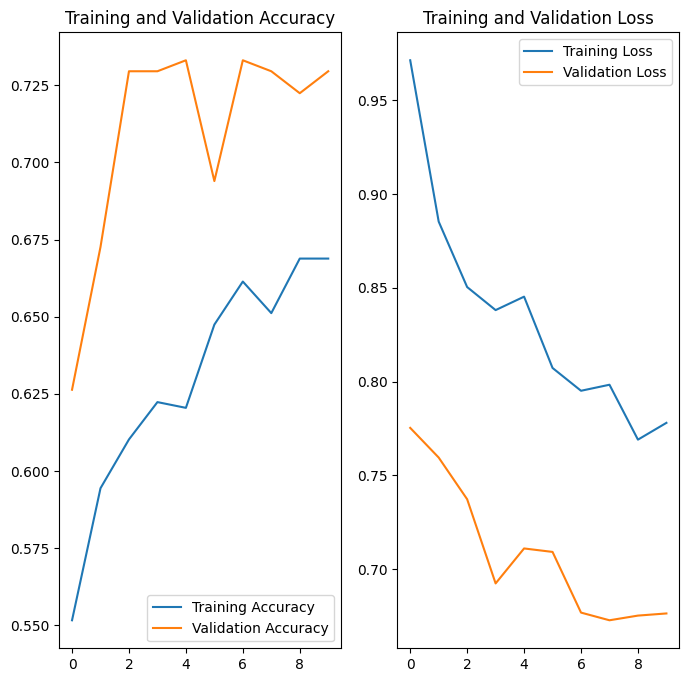

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()